In [507]:
from read_input2 import read_input
import math
import numpy
import time
import matplotlib.pyplot as plt
import random


## Lecture des données

In [508]:
start_time = time.time()

ville="Bordeaux"
ressources,ressources_unavailabilities,tasks,tasks_unavailabilities = read_input(1,ville)
# "Columbia", "Romania", "Ukraine"

In [509]:
def dist(lat1, long1, lat2, long2):
    """
    fonction renvoyant la distance en kms entre deux points décrits par leur latitude et longitude
    """
    if lat1==lat2 and long1==long2:
        return 0
    return(numpy.arccos(numpy.sin(2*numpy.pi/360*lat1)*numpy.sin(2*numpy.pi/360*lat2)+numpy.cos(2*numpy.pi/360*lat1)*numpy.cos(2*numpy.pi/360*lat2)*numpy.cos(2*numpy.pi/360*(long2-long1)))*6371)

v=5/6

L_ressources = [j for j in ressources] # tableau des objets ressources 
L_tasks = [i for i in tasks] # tableau des objets taches
number_of_ressources = len(L_ressources)
number_of_tasks = len(L_tasks)
dict_pos = {task : (task.latitude, task.longitude) for task in tasks.values()}

dict_pos = {task : (tasks[L_tasks[task]].latitude, tasks[L_tasks[task]].longitude) for task in range(number_of_tasks)}

#distance[a][b] donne la distance de la tâche a vers la tâche b
distances = [[dist(tasks[L_tasks[a]].latitude,tasks[L_tasks[a]].longitude, tasks[L_tasks[b]].latitude, tasks[L_tasks[b]].longitude) for b in range(number_of_tasks)] for a in range(number_of_tasks)]

#distance_m[j][i] donne la distance de la maison de j la tâche i
distances_m = [[dist(ressources[L_ressources[j]].latitude,ressources[L_ressources[j]].longitude, tasks[L_tasks[i]].latitude, tasks[L_tasks[i]].longitude) for i in range(number_of_tasks)] for j in range(number_of_ressources)]

dejaVu=[]

#PARAMETRES A REGLER
VERSION = 1 #Version de l'algorithme
MAXTIME = 2 #Durée d'execution maximale

NUMBERMUTATIONS = 1000
INTRAITER1 = 100
INTRAITER2 = 100
INTERITER1 = 100
INTERITER2 = 100

NUMBERITERATIONS = 10
DELTAOBJ = 1

## Functions

In [510]:
def generate_time(task_list,r):
    """
    input : list of tasks indices
    output : list of integers
    generates a time table from a list of ordered tasks
    # trajets debut et fin de journee
    """
    time=[]
    if len(task_list):
        time.append(tasks[L_tasks[task_list[0]]].openingTime+distances_m[r][task_list[0]]/v)
    for i in range(1,len(task_list)):
        time.append(max((tasks[L_tasks[task_list[i]]].openingTime,time[-1]+distances[task_list[i]][task_list[i-1]]/v+tasks[L_tasks[task_list[i-1]]].duration)))
    return(time)



In [511]:
def employees_by_level():
    """
    output : list of employees ids from level 1 to level 3
    """
    employees=[]
    for i in range(number_of_ressources):
        if ressources[L_ressources[i]].level==1:
            employees.append(i)
    for i in range(number_of_ressources):
        if ressources[L_ressources[i]].level==2:
            employees.append(i)
    for i in range(number_of_ressources):
        if ressources[L_ressources[i]].level==3:
            employees.append(i)
    return(employees)


In [512]:
def tasks_by_level():
    """
    output : list of tasks ids from level 1 to level 3, with second sort by starttime
    """
    ordered_tasks=[]
    tmp=[]
    for i in range(number_of_tasks):
        if tasks[L_tasks[i]].level==1:
            tmp.append(i)
    tmp.sort(key=lambda i:tasks[L_tasks[i]].openingTime)
    ordered_tasks.extend(tmp)    
    tmp=[]
    for i in range(number_of_tasks):
        if tasks[L_tasks[i]].level==2:
            tmp.append(i)
    tmp.sort(key=lambda i:tasks[L_tasks[i]].openingTime)
    ordered_tasks.extend(tmp)    
    tmp=[]
    for i in range(number_of_tasks):
        if tasks[L_tasks[i]].level==3:
            tmp.append(i)
    tmp.sort(key=lambda i:tasks[L_tasks[i]].openingTime)
    ordered_tasks.extend(tmp)
    return(ordered_tasks)

In [513]:
def is_feasible(employee,task_list,hours_list):
    """
    input : employee id, employee task list (by id), employee hours list (by id)
    true if feasible
    # add tasks and ressources unavailabilities
    # trajets debut et fin de journee
    """
    if len(hours_list):
        if hours_list[-1]+tasks[L_tasks[task_list[-1]]].duration>ressources[L_ressources[employee]].workingEnd:
            return False
    return True

In [514]:
def initial_task_assignementv1(ordered_tasks, ordered_employees):
    """
    output : list of the unattributed tasks (by id)
    modifies the attributes tasks and hours of the ressources to assign tasks to the employees
    # change the algo to avoid holes in the timetables
    # intégrer les conditions de la v2
    """
    unattributed_tasks=[]
    for t in ordered_tasks:
        unattributed = True
        r=0
        while unattributed and r<len(ordered_employees):
            if ressources[L_ressources[ordered_employees[r]]].level>=tasks[L_tasks[t]].level:
                tasks_tmp = ressources[L_ressources[ordered_employees[r]]].tasks.copy()
                tasks_tmp.append(t)
                hours_tmp = generate_time(tasks_tmp,ordered_employees[r])
                if is_feasible(r,tasks_tmp,hours_tmp):
                    ressources[L_ressources[ordered_employees[r]]].tasks = tasks_tmp
                    ressources[L_ressources[ordered_employees[r]]].hours = hours_tmp
                    unattributed=False
            r+=1
        if unattributed:
            unattributed_tasks.append(t)
    
    return(unattributed_tasks)

In [515]:
# def initial_task_assignementv2(ordered_tasks, ordered_employees):
#     """
#     output : list of the unattributed tasks (by id)
#     modifies the attributes tasks and hours of the ressources to assign tasks to the employees
#     takes into account the distance from the task to the employee
#     # change the algo to avoid holes in the timetables
#     # intégrer les conditions de la v2
#     """
#     unattributed_tasks=ordered_tasks
#     while no_change:
#     for t in ordered_tasks:
#         unattributed = True
#         r=0
#         while unattributed and r<len(ordered_employees):
#             if ressources[L_ressources[ordered_employees[r]]].level>=tasks[L_tasks[t]].level:
#                 tasks_tmp = ressources[L_ressources[ordered_employees[r]]].tasks.copy()
#                 tasks_tmp.append(t)
#                 hours_tmp = generate_time(tasks_tmp,ordered_employees[r])
#                 if is_feasible(r,tasks_tmp,hours_tmp):
#                     ressources[L_ressources[ordered_employees[r]]].tasks = tasks_tmp
#                     ressources[L_ressources[ordered_employees[r]]].hours = hours_tmp
#                     unattributed=False
#             r+=1
#         if unattributed:
#             unattributed_tasks.append(t)
    
#     return(unattributed_tasks)

In [516]:
def objective_function():
    """
    returns the total objective function in time,
    -> the objective is to minimize it,
    """
    tot = 0
    for r in range(number_of_ressources):
        task_list = ressources[L_ressources[r]].tasks
        if len(task_list):
            tot+= (distances_m[r][task_list[0]]+distances_m[r][task_list[-1]])/v
        for i in range(len(task_list[:-1])):
            tot += distances[task_list[i]][task_list[i+1]]/v
    return tot

In [517]:
def mutation_intrav1(r, obj):
    """
    input : r (employee id), obj (current state objective function)
    output : returns true if a change has been made, and the updated objective function
    modifies the attributes tasks and hours of an employee to optimize his distances performing an intra tasks flip
    # faire plein de mutations au début et de moins en moins après
    # insérer une tâche 
    """
    i = 0
    obj_previous = obj
    change=False
    while i<INTRAITER2: ### PARAMETER TO SET
        tasks_list = ressources[L_ressources[r]].tasks.copy() + ["start", "end"]
        ids = random.sample(tasks_list,2)
        a,b = ids[0],ids[1]
        if a=="start" and b!="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            tasks_list.remove(b)
            tasks_list = [b] + tasks_list
        elif b=="start" and a!="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            tasks_list.remove(a)
            tasks_list = [a] + tasks_list
        elif b!="start" and a=="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            tasks_list.remove(b)
            tasks_list = tasks_list + [b]
        elif a!="start" and b=="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            tasks_list.remove(a)
            tasks_list = tasks_list + [a]
        elif a!="start" and a!="end" and b!="start" and b!="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            ia,ib = tasks_list.index(a), tasks_list.index(b)
            tasks_list[ia], tasks_list[ib]=b, a

        if not(type(a)==str and type(b)==str):
            hours_tmp = generate_time(tasks_list,r)
            if is_feasible(r,tasks_list,hours_tmp):
                    tmp1=ressources[L_ressources[r]].tasks
                    tmp2=ressources[L_ressources[r]].hours
                    ressources[L_ressources[r]].tasks = tasks_list
                    ressources[L_ressources[r]].hours = hours_tmp
                    obj_new = objective_function()
                    if obj_new < obj_previous:
                        obj_previous=obj_new
                        change = True
                    else:
                        ressources[L_ressources[r]].tasks = tmp1
                        ressources[L_ressources[r]].hours = tmp2

        i+=1
        
    return(change,obj_previous)

In [518]:
def mutation_intrav2(r, obj):
    """
    input : r (employee id), obj (current state objective function)
    output : returns true if a change has been made, and the updated objective function
    modifies the attributes tasks and hours of an employee to optimize his distances performing an intra tasks flip
    # faire plein de mutations au début et de moins en moins après
    # insérer une tâche 
    """
    i = 0
    obj_previous = obj
    change=False
    while i<INTRAITER2: ### PARAMETER TO SET
        tasks_list = ressources[L_ressources[r]].tasks.copy() + ["start", "end"]
        ids = random.sample(tasks_list,2)
        a,b = ids[0],ids[1]
        if a=="start" and b!="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            tasks_list.remove(b)
            tasks_list = [b] + tasks_list
        elif b=="start" and a!="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            tasks_list.remove(a)
            tasks_list = [a] + tasks_list
        elif b!="start" and a=="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            tasks_list.remove(b)
            tasks_list = tasks_list + [b]
        elif a!="start" and b=="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            tasks_list.remove(a)
            tasks_list = tasks_list + [a]
        elif a!="start" and a!="end" and b!="start" and b!="end":
            tasks_list = ressources[L_ressources[r]].tasks.copy()
            ia,ib = tasks_list.index(a), tasks_list.index(b)
            tasks_list[ia], tasks_list[ib]=b, a

        if not(type(a)==str and type(b)==str):
            hours_tmp = generate_time(tasks_list,r)
            if is_feasible(r,tasks_list,hours_tmp):
                    tmp1=ressources[L_ressources[r]].tasks
                    tmp2=ressources[L_ressources[r]].hours
                    ressources[L_ressources[r]].tasks = tasks_list
                    ressources[L_ressources[r]].hours = hours_tmp
                    obj_new = objective_function()
                    s=hacher()
                    if obj_new < obj_previous+DELTAOBJ and s not in dejaVu:
                        obj_previous=obj_new
                        change = True
                        dejaVu.append(s)
                    else:
                        ressources[L_ressources[r]].tasks = tmp1
                        ressources[L_ressources[r]].hours = tmp2

        i+=1
        
    return(change,obj_previous)

In [519]:
def mutation_interv2(r1,r2,obj):
    """
    input : a,b, (employees ids), obj (current state objective function)
    output : returns true if a change has been made, and the updated objective function
    modifies the attributes tasks and hours of two employees to optimize distances
    # echanger aussi avec la reserve 
    # pour chaque mutation inter faire aussi des mutations intra avant de checker la faisabilité
    """
    i = 0
    change = False
    obj_previous = obj
    while i<INTERITER1: ### PARAMETER TO SET
        tasks_list1 = ressources[L_ressources[ordered_employees[r1]]].tasks.copy() + ["nothing"]
        tasks_list2 = ressources[L_ressources[ordered_employees[r2]]].tasks.copy() + ["nothing"]
        a = random.sample(tasks_list1,1)[0]
        b = random.sample(tasks_list2,1)[0]
        tasks_list1 = ressources[L_ressources[ordered_employees[r1]]].tasks.copy()
        tasks_list2 = ressources[L_ressources[ordered_employees[r2]]].tasks.copy()
        li=len(tasks_list1)+len(tasks_list2)
        if b=="nothing" and a!="nothing":
            tasks_list1.remove(a)
            tasks_list2.insert(random.randint(0,len(tasks_list2)),a)
        elif a=="nothing" and b!="nothing":
            tasks_list2.remove(b)
            tasks_list1.insert(random.randint(0,len(tasks_list1)),b)
        elif a!="nothing" and b!="nothing":
            tasks_list1.remove(a)
            tasks_list2.remove(b)
            tasks_list2.insert(random.randint(0,len(tasks_list2)),a)
            tasks_list1.insert(random.randint(0,len(tasks_list1)),b)
        try:
            assert li==len(tasks_list1)+len(tasks_list2)
        except:
            print(tasks_list1,tasks_list2)

        if not(type(a)==str and type(b)==str):
            hours_tmp1 = generate_time(tasks_list1,r1)
            hours_tmp2 = generate_time(tasks_list2,r2)
            if is_feasible(r1,tasks_list1,hours_tmp1) and is_feasible(r2,tasks_list2,hours_tmp2):
                    tmp1=ressources[L_ressources[r1]].tasks
                    tmp2=ressources[L_ressources[r1]].hours
                    tmp3=ressources[L_ressources[r2]].tasks
                    tmp4=ressources[L_ressources[r2]].hours
                    ressources[L_ressources[r1]].tasks = tasks_list1
                    ressources[L_ressources[r1]].hours = hours_tmp1
                    ressources[L_ressources[r2]].tasks = tasks_list2
                    ressources[L_ressources[r2]].hours = hours_tmp2
                    obj_new = objective_function()
                    s=hacher()
                    if obj_new < obj_previous + DELTAOBJ  and s not in dejaVu:
                        obj_previous=obj_new
                        change = True
                        dejaVu.append(s)
                    else:
                        ressources[L_ressources[r1]].tasks = tmp1
                        ressources[L_ressources[r1]].hours = tmp2
                        ressources[L_ressources[r2]].tasks = tmp3
                        ressources[L_ressources[r2]].hours = tmp4

        i+=1
    return(change,obj_previous)

In [520]:
def mutation_interv1(r1,r2,obj):
    """
    input : a,b, (employees ids), obj (current state objective function)
    output : returns true if a change has been made, and the updated objective function
    modifies the attributes tasks and hours of two employees to optimize distances
    # echanger aussi avec la reserve 
    # pour chaque mutation inter faire aussi des mutations intra avant de checker la faisabilité
    """
    i = 0
    change = False
    obj_previous = obj
    while i<INTERITER1: ### PARAMETER TO SET
        tasks_list1 = ressources[L_ressources[ordered_employees[r1]]].tasks.copy() + ["nothing"]
        tasks_list2 = ressources[L_ressources[ordered_employees[r2]]].tasks.copy() + ["nothing"]
        a = random.sample(tasks_list1,1)[0]
        b = random.sample(tasks_list2,1)[0]
        tasks_list1 = ressources[L_ressources[ordered_employees[r1]]].tasks.copy()
        tasks_list2 = ressources[L_ressources[ordered_employees[r2]]].tasks.copy()
        if b=="nothing" and a!="nothing":
            tasks_list1.remove(a)
            tasks_list2.insert(random.randint(0,len(tasks_list2)),a)
        elif a=="nothing" and b!="nothing":
            tasks_list2.remove(b)
            tasks_list1.insert(random.randint(0,len(tasks_list1)),b)
        elif a!="nothing" and b!="nothing":
            tasks_list1.remove(a)
            tasks_list2.remove(b)
            tasks_list2.insert(random.randint(0,len(tasks_list2)),a)
            tasks_list1.insert(random.randint(0,len(tasks_list1)),b)
        
        if not(type(a)==str and type(b)==str):
            hours_tmp1 = generate_time(tasks_list1,r1)
            hours_tmp2 = generate_time(tasks_list2,r2)
            if is_feasible(r1,tasks_list1,hours_tmp1) and is_feasible(r2,tasks_list2,hours_tmp2):
                    tmp1=ressources[L_ressources[r1]].tasks
                    tmp2=ressources[L_ressources[r1]].hours
                    tmp3=ressources[L_ressources[r2]].tasks
                    tmp4=ressources[L_ressources[r2]].hours
                    ressources[L_ressources[r1]].tasks = tasks_list1
                    ressources[L_ressources[r1]].hours = hours_tmp1
                    ressources[L_ressources[r2]].tasks = tasks_list2
                    ressources[L_ressources[r2]].hours = hours_tmp2
                    obj_new = objective_function()
                    if obj_new < obj_previous:
                        obj_previous=obj_new
                        change = True
                    else:
                        ressources[L_ressources[r1]].tasks = tmp1
                        ressources[L_ressources[r1]].hours = tmp2
                        ressources[L_ressources[r2]].tasks = tmp3
                        ressources[L_ressources[r2]].hours = tmp4

        i+=1
    return(change,obj_previous)

In [521]:
import hashlib
def hacher():
    s=""
    for r in range(number_of_ressources):
        s+=str(ressources[L_ressources[r]].tasks)+"\n"
    return hashlib.md5(s.encode('utf-8')).hexdigest()


## Main code

In [522]:
ordered_tasks = tasks_by_level()
ordered_employees = employees_by_level()

# first task assignement generation
if VERSION==1:
    unattributed_tasks = initial_task_assignementv1(ordered_tasks, ordered_employees)
else:
    unattributed_tasks = initial_task_assignementv1(ordered_tasks, ordered_employees) #A changer avec V2

print(ressources[L_ressources[0]].level)
print(len(ordered_employees),number_of_ressources)

for r in range(number_of_ressources):
    assert len(ressources[L_ressources[ordered_employees[r]]].tasks) == len(ressources[L_ressources[ordered_employees[r]]].hours)

# print("ATTRIBUTION INITIALE")
# for r in range(number_of_ressources):
#     print("attribution initiale pour", L_ressources[r])
#     print(ressources[L_ressources[ordered_employees[r]]].tasks)
#     print(ressources[L_ressources[ordered_employees[r]]].hours)

# mutations
start_time = time.time()
last_change = 0
time_exec = 0
i = 0
obj = objective_function()
print("Fonction objectif initiale : ",obj)
d=0
for r in range(number_of_ressources):
    for t in ressources[L_ressources[r]].tasks:
        d+=tasks[L_tasks[t]].duration
print("Durée des tâches : ",d)
while last_change<NUMBERMUTATIONS and time_exec < 60*MAXTIME:
    # mutation intra
    for r in range(number_of_ressources):
        if VERSION==1:
            change,obj=mutation_intrav1(r,obj)
        else:
            change,obj=mutation_intrav2(r,obj)
    if change:
        last_change = 0
    else:
        last_change+=1

    # mutation inter
    if number_of_ressources>1:
        for r1 in range(number_of_ressources):
            for r2 in range(number_of_ressources):
                if r2 > r1:
                    if VERSION==1:
                        change,obj=mutation_interv1(r1,r2,obj)
                    else:
                        change,obj=mutation_interv2(r1,r2,obj)
    if change:
        last_change = 0
    else:
        last_change+=1

    time_exec = time.time() - start_time
    i+=1

# print("ATTRIBUTION APRES MUTATION")
# for r in range(number_of_ressources):
#    print("attribution post mutation pour", L_ressources[r])
#    print(ressources[L_ressources[ordered_employees[r]]].tasks)
#    print(ressources[L_ressources[ordered_employees[r]]].hours)

print("Fonction objectif finale : ",obj)
d=0
for r in range(number_of_ressources):
    for t in ressources[L_ressources[r]].tasks:
        d+=tasks[L_tasks[t]].duration
print("Durée des tâches : ",d)

performed=[-1 for i in range(number_of_tasks)]
time=[0 for i in range(number_of_tasks)]
for i in range(number_of_ressources):
    for j,t in enumerate(ressources[L_ressources[i]].tasks):
        performed[t]=i
        time[t]=ressources[L_ressources[i]].hours[j]
t=open("Solution"+ville+"V3ByV4.txt",'w'.format(ville))
res="taskId;performed;employeeName;startTime;\n"
for j in range(number_of_tasks):
  p=False
  if performed[j]!=-1:
    res+="{};{};{};{};\n".format(L_tasks[j],1,L_ressources[performed[j]],time[j])
    p=True
  if not p:
    res+="{};0;;;\n".format(L_tasks[j])
#print(res)
t.write(res)
t.close()

2
2 2
Fonction objectif initiale :  391.4355788035091
Durée des tâches :  600
Fonction objectif finale :  270.89753044693805
Durée des tâches :  600


## Checkers

In [523]:
# check que les techniciens ont le bon niveau et les bonnes compétences pour les tâches exécutées
a = True
for i in range(number_of_ressources):
    for j in range(number_of_tasks):
        if j in ressources[L_ressources[i]].tasks :
            # check que le skill est bon
            if ressources[L_ressources[i]].skill!=tasks[L_tasks[i]].skill:
                print("fail r,t ",i,j)
                a = False
            # check que le level est bon
            if ressources[L_ressources[i]].level < tasks[L_tasks[j]].level:
                print("fail r,t ",i,j)
                a = False
if a :
    print("Les techniciens ont bien les bonnes compétences et le bon niveau pour toutes les tâches exécutées")

fail r,t  1 5
fail r,t  1 8


## Solution visualisation

In [524]:
y = {(r,a,b) : 0 for r in range(number_of_ressources) for a in range(number_of_tasks) for b in range(number_of_tasks)}
d = {(r,t) : 0 for r in range(number_of_ressources) for t in range(number_of_tasks)}
f = {(r,t) : 0 for r in range(number_of_ressources) for t in range(number_of_tasks)}

for r in range(number_of_ressources):
    taches = ressources[L_ressources[r]].tasks
    for i in range(len(taches)-1) :
        y[(r,taches[i],taches[i+1])]=1
    if len(taches)>0:
        d[(r,taches[0])]=1
        f[(r,taches[-1])]=1

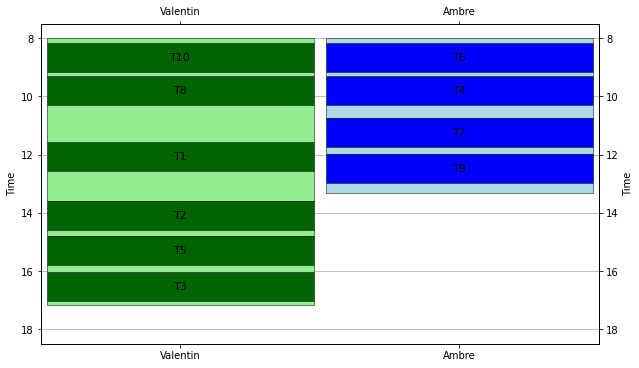

In [525]:
list_colors = ['darkgreen', 'blue', 'red', 'green', 'purple', 'red', 'purple', 'pink', 'orange', 'darkblue', 'gray', 'darkred']
list_light_colors = ['lightgreen','lightblue','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow']


operators=[L_ressources[r] for r in range(number_of_ressources)]
colors=list_colors[0:number_of_ressources]
light_colors=list_light_colors[0:number_of_ressources]

fig=plt.figure(figsize=(10,5.89))

# Set Axis
ax=fig.add_subplot(111)
ax.yaxis.grid()
ax.set_xlim(0.5,len(operators)+0.5)
ax.set_ylim(18.5, 7.5)
ax.set_xticks(range(1,len(operators)+1))
ax.set_xticklabels(operators)
ax.set_ylabel('Time')

# Set Second Axis
ax2=ax.twiny().twinx()
ax2.invert_yaxis()
ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(ax.get_ylim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(operators)
ax2.set_ylabel('Time')

for r in range(number_of_ressources):
    color_r = colors[r]
    light_color_r = light_colors[r]
    operator_room = r+1-0.48
    for a in range(number_of_tasks):
        if a in ressources[L_ressources[r]].tasks :
            event="T"+str(a+1)
            i = ressources[L_ressources[r]].tasks.index(a)
            start = ( ressources[L_ressources[r]].hours[i] )/60
            end = (ressources[L_ressources[r]].hours[i]+tasks[L_tasks[a]].duration)/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=color_r, edgecolor='k', linewidth=0.5)
            #plt.text(operator_room+0.02, start+0.05 ,'{}:{}'.format(ressources[L_ressources[r]].hours[i]//60, ressources[L_ressources[r]].hours[i]%60), va='top', fontsize=6)
            #plt.text(operator_room+0.02, end-0.05,'{}:{}'.format((start+tasks[L_tasks[a]].duration)//60, (start+tasks[L_tasks[a]].duration)%60), va='bottom', fontsize=6)
            plt.text(operator_room+0.48, (start+end)*0.5, event, ha='center', va='center', fontsize=11)
        for b in range(number_of_tasks):
            if round(y[(r,a,b)]) == 1:
                i = ressources[L_ressources[r]].tasks.index(a)
                start = ( ressources[L_ressources[r]].hours[i] +tasks[L_tasks[b]].duration)/60
                end = start+(distances[a][b]/v)/60
                plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
        if round(d[(r,a)]) == 1:
            i = ressources[L_ressources[r]].tasks.index(a)
            start = (ressources[L_ressources[r]].hours[i]-distances_m[r][a]/v)/60
            end = ressources[L_ressources[r]].hours[i]/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
        if round(f[(r,a)]) == 1:
            i = ressources[L_ressources[r]].tasks.index(a)
            start=(ressources[L_ressources[r]].hours[i] + tasks[L_tasks[a]].duration)/60
            end=start+(distances_m[r][a]/v)/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)

plt.savefig('timetable_{}_V3.png'.format(ville), dpi=500, transparent=False)
plt.show()

In [526]:
unattributed_tasks

[]

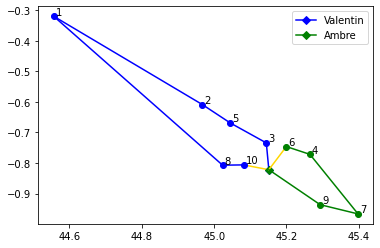

In [527]:
import matplotlib.pyplot as plt

list_colors = ['b','g','r','c','darkviolet','y','b','g','r','c','darkviolet','y','b','g','r','c','darkviolet','y','b','g','r','c','darkviolet','y']
list_light_colors = ['lightblue','lightgreen','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow']
number_of_colors = len(list_colors)
counter = 0
done_tasks=list()
for r in range(number_of_ressources):
  color_r = list_colors[counter % number_of_colors]
  plt.plot(ressources[L_ressources[r]].latitude,ressources[L_ressources[r]].longitude, color = color_r, marker="D", label=L_ressources[r])
  for a in range(number_of_tasks):
    for b in range(number_of_tasks):
      if round(y[(r,a,b)]) == 1:
        plt.plot([tasks[L_tasks[a]].latitude, tasks[L_tasks[b]].latitude], [tasks[L_tasks[a]].longitude, tasks[L_tasks[b]].longitude], color = color_r)
    if round(d[(r,a)]) == 1:
      plt.plot([tasks[L_tasks[a]].latitude, ressources[L_ressources[r]].latitude], [tasks[L_tasks[a]].longitude, ressources[L_ressources[r]].longitude], color = 'gold')
    if round(f[(r,a)]) == 1:
      plt.plot([tasks[L_tasks[a]].latitude, ressources[L_ressources[r]].latitude], [tasks[L_tasks[a]].longitude, ressources[L_ressources[r]].longitude], color = color_r)
    if a in ressources[L_ressources[r]].tasks :
      done_tasks.append(a)
      plt.plot(tasks[L_tasks[a]].latitude, tasks[L_tasks[a]].longitude, color = color_r, marker="o")
      plt.annotate(str(a+1), [tasks[L_tasks[a]].latitude+0.005, tasks[L_tasks[a]].longitude+0.005])
  counter+=1

for t in range(number_of_tasks):
  if t not in done_tasks:
    plt.plot(tasks[L_tasks[t]].latitude, tasks[L_tasks[t]].longitude, color = 'black', marker="o")
    plt.annotate(str(t+1), [tasks[L_tasks[t]].latitude+0.005, tasks[L_tasks[t]].longitude+0.005])
plt.legend()
plt.savefig('parcours_{}_V3.png'.format(ville), dpi=500, transparent=False)
plt.show()